# Programming for Data Analysis - Project


## Abstract

This Jupyter Python notebook explores a publicly-available dataset originating from the biennial Critical Assessment of protein Structure Prediction (CASP) competition, series 5-9. After first performing exploratory data analysis on the dataset, different tools are used to create a synthetic dataset *via* different Python libraries. For the synthesis, random numbers was generated following the distribution of each attribute. Lastly, a comparison is made between the original and the synthetic dataset to evaluate the accurary of the entire data synthesis process.

refs:
Mukhopadhyay_revised.pdf (desktop)
http://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure
https://en.wikipedia.org/wiki/CASP
Dataflow Acceleration of scikit-learn Gaussian Process Regression (desktop)



Specifically, in this project you should:
• Choose a real-world phenomenon that can be measured and for which you could collect at least one-hundred data points across at least four different variables.
• Investigate the types of variables involved, their likely distributions, and their relationships with each other.
• Synthesise/simulate a data set as closely matching their properties as possible.
• Detail your research and implement the simulation in a Jupyter notebook – the data set itself can simply be displayed in an output cell within the notebook.


## Table of Contents

1. [Introduction](#introduction)
1. [Exploratory Data Analysis (EDA)](#eda)
1. [Methods for Data Synthesis / Simulation](#methodsForSimulation)
1. [Generation of a synthetic dataset](#generationOfSyntheticDataset)
1. [RMSD](#RMSD)
1. [Total Surface Area](#TotalArea)
1. [Non-polar exposed area](#NonpolarExposedArea)
1. [Fractional area of exposed non polar residue](#FractionalAreaExposedNonPolarResidue)
1. [Fractional area of exposed non polar part of residue](#FractionalAreaExposedNonPolarPartOfResidue)
1. [Molecular mass weighted exposed area](#MolecularMassWeightedExposedArea)
1. [Average deviation from standard exposed area of residue](#AverageDeviationFromStandardExposedAreaOfResidue)
1. [Euclidian distance](#EuclidianDistance)
1. [Secondary structure penalty](#SecondaryStructurePenalty)
1. [Spatial distribution constraints](#SpatialDistributionConstraints)


## <a id='introduction'></a>Introduction

Proteins are complex molecules (macromolecules) responsible for performing a multitude of biological functions. These include:


| Name | Function |
| ---  | ---      |
| Keratin | Component of hair and nail |
| Collagen | Component of skin |
| Insulin | Responsible for regulating sugar and fat level |


An important aspect in the field of protein biochemistry is understanding how protein structures relate to their molecular function - which led to the emergence of the structural biology field. This active area of research applies experimental techniques such as X-ray and neutron crystallography, and electron microscopy to determine the three-dimensional structures of protein such that questions on their evolutionary relationships and exploitability for healthcare can be answered.

However, experimental techniques suffer from inherent drawbacks - they require highly-pure and stable physical samples that can be difficult to obtain in sufficient quantities, as well as human expertise to convert data to three-dimensional models that can be instinctively interpreted by researchers from other fields. Computational biology approaches are one way to overcome these drawbacks. By making certain assumptions, we can use computers to solve structures. For instance, having solved one protein structure, we can predict that another similar protein will likely have the same overall structure, albeit with minor differences (homology modeling).

Alternatively, we can also use fundamental physics to note that a certain protein sequence will only fold into a particular structure as there will be attraction and repulsion forces among the different atoms (*de novo* prediction). The idea that there is no random sampling of all possible conformations during the process of protein folding is captured by (Levinthal's paradox)[https://en.wikipedia.org/wiki/Levinthal%27s_paradox], where it was postulated that random sampling leading to the correct conformation would take more time than the age of the universe.

In order to judge the performance of various algorithms, CASP has been organized by the structural biology community as an open venue to learn from each other as often no one method is the best for *all* types of problems. Complementary techniques, including the use of lower resolution (less informative) tools such as circular dichroism, can also help to determine a model that is as close to the actual structure as possible.

In this notebook, we will look at the CASP dataset and understand the relationship among all the variables and their individual distribtions before using Python libraries to generate a synthetic dataset that mimicks the experimental values.

In order to not reinvent the wheel, we will use pre-existing Python libraries to achieve our goal.


In [31]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import pandas as pd
df = pd.read_csv("CASP.csv") # http://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure
import seaborn as sns

# to make interactive plots with plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly import tools

# https://pypi.org/project/fitter/
# original fitter is here:
# but we use https://github.com/caiostringari/fitter/tree/master
# (to install: pip install --upgrade https://github.com/caiostringari/fitter/tarball/master)
from fitter import Fitter

from pylab import *
from scipy.optimize import curve_fit
import scipy.interpolate as interpolate

# import scipy distributions that are needed later
from scipy.stats import moyal, exponnorm, johnsonsu, norm, genlogistic, invgauss, burr

## <a id='eda'></a>Exploratory Data Analysis (EDA)
We will first look at the data structure and make modifications as required.

In [32]:
df

RMSD        F1       F2       F3        F4            F5        F6  \
0      17.284  13558.30  4305.35  0.31754  162.1730  1.872791e+06  215.3590   
1       6.021   6191.96  1623.16  0.26213   53.3894  8.034467e+05   87.2024   
2       9.275   7725.98  1726.28  0.22343   67.2887  1.075648e+06   81.7913   
3      15.851   8424.58  2368.25  0.28111   67.8325  1.210472e+06  109.4390   
4       7.962   7460.84  1736.94  0.23280   52.4123  1.021020e+06   94.5234   
5       1.700   5117.30  1120.99  0.21905   51.6732  6.727227e+05   79.5911   
6       9.314   5924.16  1625.27  0.27434   70.2103  8.285145e+05   76.8064   
7       1.985   6882.15  1791.22  0.26027   77.2501  9.165165e+05   96.6785   
8       1.915  12090.00  4190.74  0.34662  129.0020  1.687508e+06  186.3090   
9       1.495   7400.24  1881.95  0.25430   82.9320  1.023846e+06  104.6970   
10     12.118   6556.77  1612.77  0.24597   71.6315  8.915443e+05   93.5329   
11      0.884   8828.21  2658.63  0.30115   90.8578  1.233384e+06  123.6860   
12      7.913   5637.37  2665.83  0.47288   49.8566  7.716355e+05   95.7431   
13     14.103   9021.10  3097.91  0.34340   98.1155  1.244160e+06  121.3480   
14      6.581  17572.20  5226.42  0.29742  227.7690  2.434431e+06  296.8000   
15      6.110  12330.60  4380.20  0.35523  195.9300  1.710155e+06  232.1540   
16      1.339   8478.55  2206.94  0.26029   91.5054  1.199770e+06  128.1660   
17      2.554   9147.09  2828.26  0.30919  104.0500  1.291447e+06  131.3580   
18      3.805   3905.51  1102.49  0.28229   34.2034  5.643988e+05   48.1646   
19     18.645  15620.90  5834.18  0.37348  153.4760  2.184645e+06  251.2250   
20      8.114  18679.00  5966.18  0.31940  179.7570  2.650897e+06  268.6610   
21     18.404  13605.50  4766.37  0.35032  139.7930  1.925985e+06  182.1950   
22     19.379   8693.56  3265.99  0.37567   55.4973  1.258363e+06  126.9280   
23     17.598   7727.36  1370.27  0.17732   77.5656  1.035614e+06  103.1770   
24     16.102   8865.32  3317.32  0.37419   95.8075  1.223688e+06  122.7480   
25     14.923   8259.29  2719.28  0.32923   76.1237  1.087133e+06  122.1430   
26      1.655   7136.22  2645.28  0.37068   64.1673  1.032920e+06   93.2759   
27      4.128   6922.15  2143.02  0.30958   63.6012  9.896310e+05   91.6472   
28      1.477   6449.78  1439.30  0.22315   74.7722  8.497845e+05   90.5322   
29      2.165  13274.30  3989.12  0.30051  169.7460  1.855448e+06  198.6440   
...       ...       ...      ...      ...       ...           ...       ...   
45700   0.966  23403.50  5511.79  0.23551  319.1290  3.224178e+06  407.9570   
45701   5.546  18403.60  4882.31  0.26529  245.5710  2.559338e+06  294.5570   
45702   3.581  13696.00  4088.79  0.29853  145.3500  1.844331e+06  211.9420   
45703   1.661   6405.36  2182.59  0.34074   72.0344  8.836039e+05   92.7146   
45704  18.522  10840.30  5689.76  0.52487   85.2052  1.355167e+06  207.9200   
45705  18.875  11215.80  3814.74  0.34012  102.4110  1.537030e+06  179.7740   
45706  17.150   9779.31  3687.08  0.37702   82.2241  1.397476e+06  144.7080   
45707  13.678   6233.61   846.29  0.13576   52.7953  8.656223e+05   71.4992   
45708   4.758   6458.52  1380.97  0.21382   64.5865  8.980187e+05   72.4505   
45709   1.788   6226.42  1551.74  0.24921   67.6087  8.793935e+05   74.1427   
45710   3.509  13867.40  4320.27  0.31154  167.1120  1.923652e+06  216.2990   
45711   1.572   8716.67  2369.97  0.27188   83.0696  1.222297e+06  116.8790   
45712   8.221   9893.75  2426.80  0.24528   87.7843  1.396274e+06  124.5970   
45713  12.684   7353.75  2471.99  0.33615   50.5474  1.047082e+06  107.5370   
45714  17.180   9616.40  3410.33  0.35463   99.8179  1.353932e+06  150.5450   
45715   0.984   9725.16  1990.64  0.20468  104.3870  1.372349e+06  138.4390   
45716   3.619  10153.40  3390.35  0.33391   83.1698  1.410026e+06  154.4500   
45717  13.697   6074.87  1322.94  0.21777   56.0178  8.186789e+05   70.0644   
45718  11.283   3781.01  1149.39  0.30399   36.0219  5.1284

From above, we can determine that we have 10 columns (RMSD and F1-F9) of 45730 rows (data points) each. Except for the first column, the others are non-descriptive and should be renamed so avoid confusion later on. 

For illustration purposes, we do not really need all the 45730 rows, so we'll just use a random selection of 500 rows. Because the Plotly plots are interactive and have the datapoints embedded within them, a smaller number of datapoints will allow for a smaller notebook size.

To note, Plotly is capable of plotting hundreds of thousands of datapoints (big data) by using WebGL. Alternatively, the plot can be made static [by conversion into an image and then displayed inline within the notebook](https://plot.ly/python/static-image-export/).

In [33]:
# rename columns based on information from the UCI webpage
# F1 - Total surface area. 
# F2 - Non polar exposed area. 
# F3 - Fractional area of exposed non polar residue. 
# F4 - Fractional area of exposed non polar part of residue. 
# F5 - Molecular mass weighted exposed area. 
# F6 - Average deviation from standard exposed area of residue. 
# F7 - Euclidian distance. 
# F8 - Secondary structure penalty. 
# F9 - Spacial Distribution constraints (N,K Value). (typo for Spatial?)
df.rename(columns={'F1': 'Total surface area',
                   'F2': 'Non-polar exposed area',
                   'F3': 'Fractional area of exposed non-polar residue',
                   'F4': 'Fractional area of exposed non-polar part of residue',
                   'F5': 'Molecular mass weighted exposed area',
                   'F6': 'Average deviation from standard exposed area of residue',
                   'F7': 'Euclidian distance',
                   'F8': 'Secondary structure penalty',
                   'F9': 'Spatial Distribution constraints (N,K Value)'
                  }, inplace = True)

# df.corr() # calculate correlation between variables

# if required, we can use just a subset of the dataset for faster plotting, fitting etc.
# df = df.iloc[:10000] # takes first 10000 rows
# df = df.sample(n=20000) # random samples

In [4]:
trace0 = go.Box(y=df.iloc[:,0])
trace1 = go.Box(y=df.iloc[:,1])
trace2 = go.Box(y=df.iloc[:,2])
trace3 = go.Box(y=df.iloc[:,3])
trace4 = go.Box(y=df.iloc[:,4])
trace5 = go.Box(y=df.iloc[:,5])
trace6 = go.Box(y=df.iloc[:,6])
trace7 = go.Box(y=df.iloc[:,7])
trace8 = go.Box(y=df.iloc[:,8])
trace9 = go.Box(y=df.iloc[:,9])

fig = tools.make_subplots(rows=5, cols=2, print_grid=False,
                          subplot_titles= (df.columns[0], df.columns[1], df.columns[2], df.columns[3],
                                           df.columns[4], df.columns[5], df.columns[6], df.columns[7],
                                           df.columns[8], df.columns[9]
                                                          ))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)

fig.append_trace(trace5, 3, 2)
fig.append_trace(trace6, 4, 1)
fig.append_trace(trace7, 4, 2)
fig.append_trace(trace8, 5, 1)
fig.append_trace(trace9, 5, 2)

fig['layout'].update(height=800, width=1000, title='<b>Figure 1: Box Plot of CASP dataset</b>')
fig['layout'].update(showlegend=False)

# https://github.com/plotly/plotly.py/issues/985
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10)

for prop in fig.layout:
    if prop.startswith('xaxis'):
        # don't really need both xaxis label and subplot title, so turn xaxis label off
        fig.layout[prop].showticklabels = False

iplot(fig)

Although a table containing the correlation coefficents between two variables for all the variables can be obtained by using `df.corr()` function, it is too 'numerical' for a good interpretation. A better option is to use Seaborn to construct a heat map based on the data from `df.corr()`.

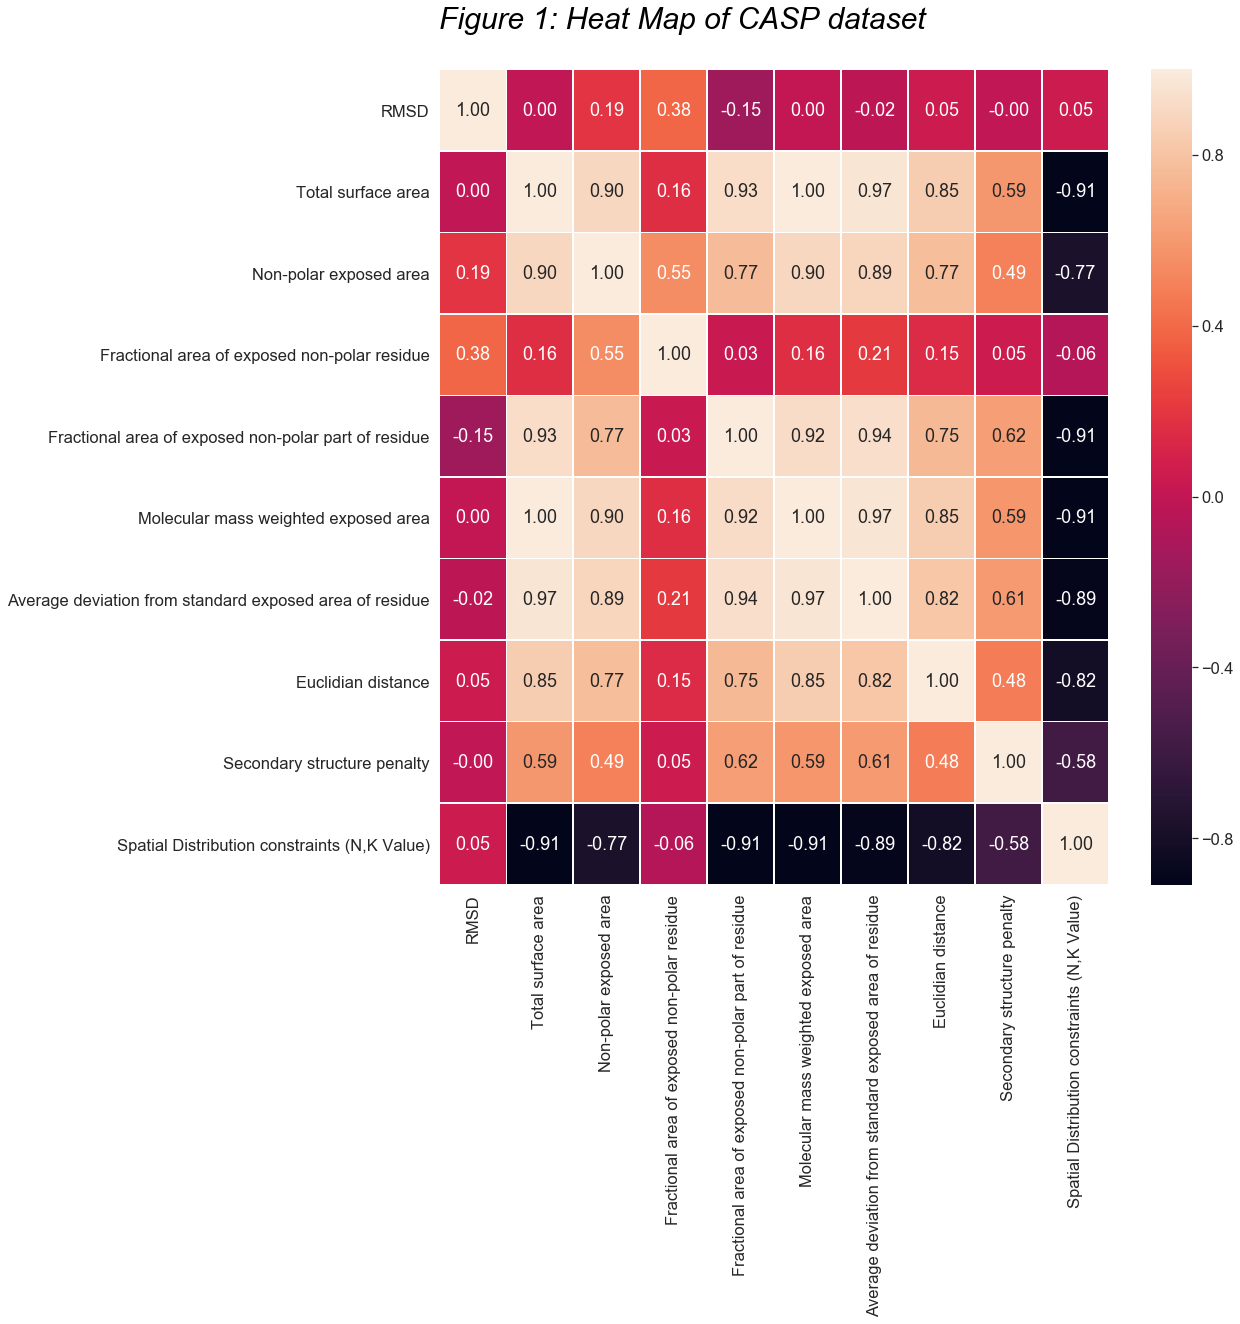

In [5]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15,15)) 
plt.text(0,-0.5, "Figure 1: Heat Map of CASP dataset", fontsize = 30, color='Black', fontstyle='italic')
# plt.tight_layout()

# according to the docs https://seaborn.pydata.org/generated/seaborn.heatmap.html and
# http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/
# we can use linewidths to create some spacing between the cells and
# fmt (format) to round 2 decimal points

# https://stackoverflow.com/questions/25790062/
sns.heatmap(df.corr(), annot=True, linewidths = 0.5, fmt='.2f');

We can make the following observations:

1. RMSD is poorly correlated with any of the other variables.
1. There is a strong positive correlation between Total surface area and non-polar exposed area, Fractional area of exposed non-polar part of residue, Molecular mass weighted exposed area, Average deviation from standard exposed area of residue, and strong negative correlation with spatial distribution constraints.
1. With the exception of RMSD and Fractional area of exposed non-polar residue, all variables have strong correlation with the spatial distribution constraints.

Based on the variable labels and the correlation coefficients above, it seems likely that some variables could be collinear, rather than truly correlated. A multivariate analysis using the `pairplot()` function can shed some light here.

In [34]:
# https://community.plot.ly/t/splom-scatter-matrix-changing-styles-of-all-axes-in-one-go/16636/2
# https://plot.ly/python/splom/

# initiate placeholders
dataPanda = []
label = ''

for column in list(df.columns):
        
    columnSplit = column.split(' ') # create a list of string from the column name
    
    for i in columnSplit:
        label = label + i + '<br>' # because plotly uses JavaScript, we can use the html <br> tag to split to next line
    
    # inspired by: https://stackoverflow.com/questions/43229013/
    for i in range(3):
        label = '<br>' + label + '<br>'
    
    label = '<i>' + label + '</i>'
    trace = dict(label = label, values = df[column])
    
    dataPanda.append(trace)
    label = '' # reset the variable for next for iteration

trace1 = go.Splom(dimensions=dataPanda, showupperhalf=False, marker=dict(size=3, color='green'))
data = [trace1]


layout = go.Layout(title = '<b>Figure 2: Scatterplot Matrix of CASP dataset</b>',
                font=dict(size=8.5), # global font
                titlefont=dict(size=20), # but we want only title to have different size
                margin = dict(l = 150, r = 20, b = 150) # layout control- left, right, bottom, top (t) and padding (pad )
                )           
    
fig = go.Figure(data=data, layout=layout)
fig['layout'].update(height=800, width=900)

iplot(fig)

In [7]:
df.describe()

RMSD  Total surface area  Non-polar exposed area  \
count  500.000000          500.000000              500.000000   
mean     8.033250         9883.043700             3035.316040   
std      6.148456         3857.011647             1457.986436   
min      0.000000         3857.830000              754.860000   
25%      2.426750         7148.115000             1969.305000   
50%      5.894000         8934.025000             2703.115000   
75%     13.277750        12141.525000             3770.895000   
max     20.762000        23787.800000             9344.450000   

       Fractional area of exposed non-polar residue  \
count                                    500.000000   
mean                                       0.303144   
std                                        0.064036   
min                                        0.122560   
25%                                        0.256987   
50%                                        0.303075   
75%                                        0.342993   
max                                        0.520230   

       Fractional area of exposed non-polar part of residue  \
count                                         500.000000      
mean                                          103.325749      
std                                            52.292058      
min                                            23.086100      
25%                                            65.002150      
50%                                            89.041900      
75%                                           132.415250      
max                                           318.155000      

       Molecular mass weighted exposed area  \
count                          5.000000e+02   
mean                           1.373991e+06   
std                            5.377586e+05   
min                            5.256624e+05   
25%                            9.825396e+05   
50%                            1.254470e+06   
75%                            1.698436e+06   
max                            3.292602e+06   

       Average deviation from standard exposed area of residue  \
count                                         500.000000         
mean                                          145.202482         
std                                            65.505652         
min                                            47.376800         
25%                                            95.807275         
50%                                           128.509500         
75%                                           178.121250         
max                                           416.875000         

       Euclidian distance  Secondary structure penalty  \
count           500.00000                   500.000000   
mean           3988.94862                    68.486000   
std            1174.25426                    51.980475   
min            1378.56000                     1.000000   
25%            3195.12000                    33.000000   
50%            3823.28500                    56.000000   
75%            4693.53500                    88.250000   
max           11648.19000                   310.000000   

       Spatial Distribution constraints (N,K Value)  
count                                    500.000000  
mean                                      34.326449  
std                                        5.859434  
min                                       17.691200  
25%                                       30.008525  
50%                                       35.130150  
75%                                       38.757025  
max                                       46.546400

It could be caused by the calculations used to determine the total surface area, which presumably is a function of xx and yy (addition).

***

## <a id='methodsForSimulation'></a>Methods for Data Synthesis / Simulation

In any case, we should look at the distribution of each variable. Scipy comes with many well-known distributions PDF, which each function takes usually two parameters - scale to control xx and loc to control mean.

While we could manually fit each distribution for each variable, we can use the `fitter` module to automatically generate the curves for us. In essence, `fitter` uses Scipy curve_fit to do xx and yy...

In essence, a synthetic dataset can be generated by the following methods:

1. For dataset related to a specific chemical or physical phenomenon, the relationship between the response and predictor variables can often be described as a mathematical equation (first principles and/or mechanistic model). Usually, the model takes the form of a differential equation. In this case, an error term referencing random numbers (noise) can be added to that model to yield a synthetic dataset.
1. For those that do not have a mathematical equation defined in the literature but follows a well-described and widely used distribution, we can use one of the [35+ `numpy.random` functions](https://docs.scipy.org/doc/numpy/reference/routines.random.html), for example `numpy.random.beta()`. Alternatively, a larger set of functions from [`scipy.stats` (about 80 functions)](http://scipy.github.io/devdocs/stats.html) can be used, for example `scipy.stats.rvs()`.

    However, we need to know the parameters, such as $\mu$ and $\sigma$ for the mean and standard deviation for a normal distribution, respectively, . This can be estimated by 'eye', trial-and-error or automated/manual curve fitting. In this project, the [Fitter package](https://pythonhosted.org/fitter/) will be used.
    
    Note that the [original GitHub repository for this package](https://github.com/cokelaer/fitter) was last updated about 2 years. Therefore, a [different branch](https://github.com/caiostringari/fitter/tree/master) with more recent updates aligned to the latest Matplotlib library will be used. For installation, use the following command in shell: `pip install --upgrade https://github.com/caiostringari/fitter/tarball/master` (`--upgrade` can be omitted if installing for the first time). 

    Simulating a dataset following a bimodal normal distribution is difficult with `numpy.random` but [doable](https://stackoverflow.com/questions/4265988/generate-random-numbers-with-a-given-numerical-distribution).

1. For these difficult cases where there are no well-known distributions, [inverse transform sampling (ITS)](http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/) can be employed.
    1. [Inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling), in essence, is a method to rescale a uniform random variable (which is what numpy.random returns - see the Programming for Data Analysis Assignment) into a desired probability distribution.
    1. The cumulative distribution function (CDF) can be thought of as the integral of the data histogram [which itself is a probability distribution function (PDF)], giving us [the percentage or the relative count plotted against the data](https://www.andata.at/en/software-blog-reader/why-we-love-the-cdf-and-do-not-like-histograms-that-much.html). CDF has a $y$ axis of [0,1].
    1. Inverting the CDF allows the sampling of the uniform values because the y-axis is turned into an x-axis of [0,1], followed by a transformation into the target distribution.

In [8]:
# http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# increase n_bins and samples to get a better sampling
def inverse_transform_sampling(data, n_bins = 200, n_samples = 500):
    
    # calculate a histogram over the data. density = True calc's a pdf
    hist, bin_edges = np.histogram(data, bins = n_bins, density=True)
    
    cum_values = np.zeros(bin_edges.shape) # return an array filled with zeros with the dimension of the bin_edges above
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges)) # cumulative sum of histogram x discrete difference
    
    inv_cdf = interpolate.interp1d(cum_values, bin_edges) # interpolate over the cumulative sum
    r = np.random.rand(n_samples) # generate a bunch of random numbers
    
    return inv_cdf(r) # return the random numbers shaped from the interpolate result above

***

## <a id='generationOfSyntheticDataset'></a>Generation of a synthetic dataset

For clarity, each column will be synthesized using one or more standard Scipy distributions and ITS followed by a graphical distribution comparison to the original (experimental) data. In the end, these synthetic columns will be assembled as a Pandas dataframe and corresponding box plots and scatter matrices generated.

### <a id='RMSD'></a>RMSD
Let's fit the RMSD first

In [9]:
RMSD_values = df['RMSD'] # get all RMSD values

f_RMSD = Fitter(RMSD_values)
f_RMSD.fit()

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning:

invalid value encountered in double_scalars



Fitted alpha distribution with error=0.1525302856104265, AIC=691.1042927384494, BIC=703.748117033716)
Fitted anglit distribution with error=0.19997964518828296, AIC=637.5398337189071, BIC=645.9690499157515)
Fitted arcsine distribution with error=0.2479536483453589, AIC=642.0450130229831, BIC=650.4742292198275)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:6532: RuntimeWarning:

divide by zero encountered in double_scalars

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:589: RuntimeWarning:

divide by zero encountered in true_divide

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:593: RuntimeWarning:

divide by zero encountered in true_divide

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1037: RuntimeWarning:

invalid value encountered in subtract



Fitted argus distribution with error=0.3972713691705073, AIC=509.6958820960231, BIC=522.3397063912897)
Fitted beta distribution with error=0.1430958381660137, AIC=626.3334254439452, BIC=643.191857837634)
Fitted betaprime distribution with error=0.12736510598544173, AIC=672.0083336420487, BIC=688.8667660357374)
Fitted bradford distribution with error=0.14595620150765942, AIC=615.4888103844687, BIC=628.1326346797352)
Fitted burr distribution with error=0.1598223328144786, AIC=653.5836470607725, BIC=670.4420794544612)
Fitted burr12 distribution with error=0.13267502154235408, AIC=667.0093514811871, BIC=683.8677838748758)
Fitted cauchy distribution with error=0.19218810772715963, AIC=755.9591935612856, BIC=764.38840975813)
Fitted chi distribution with error=0.14106336323542779, AIC=653.5566540554845, BIC=666.200478350751)
Fitted chi2 distribution with error=0.12755736359658548, AIC=670.055357961756, BIC=682.6991822570226)
Fitted cosine distribution with error=0.20282286362118723, AIC=647.7

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 15.75.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 14.25.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 14.5.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 14.875.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-p

Fitted exponpow distribution with error=0.14345529992607514, AIC=649.0741720907397, BIC=661.7179963860062)
Fitted exponweib distribution with error=0.14676531634001663, AIC=648.7366727974322, BIC=665.595105191121)
Fitted f distribution with error=0.7438603734398658, AIC=836.330806365665, BIC=853.1892387593538)
Fitted fatiguelife distribution with error=0.11146742893484449, AIC=684.9560220072904, BIC=697.5998463025569)
Fitted fisk distribution with error=0.12325550784666145, AIC=699.2378358832423, BIC=711.8816601785088)
Fitted foldcauchy distribution with error=0.13507843930105976, AIC=714.0000343339765, BIC=726.643858629243)
Fitted foldnorm distribution with error=0.14483265349325156, AIC=649.6827702603911, BIC=662.3265945556576)
Fitted frechet_l distribution with error=1.3545323076511786, AIC=882.9114961492163, BIC=895.5553204444828)
Fitted frechet_r distribution with error=0.25382936278836665, AIC=741.8961716571416, BIC=754.5399959524082)
Fitted gamma distribution with error=0.127556

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:3080: RuntimeWarning:

divide by zero encountered in power



Fitted gausshyper distribution with error=0.11161303338877165, AIC=643.4056653727149, BIC=668.6933139632481)
Fitted genexpon distribution with error=0.15693370324150294, AIC=670.4872232342926, BIC=691.5602637264036)
Fitted genextreme distribution with error=0.12717315312293093, AIC=700.3169010859458, BIC=712.9607253812123)
Fitted gengamma distribution with error=0.1428201444575772, AIC=658.1391015000219, BIC=674.9975338937106)
Fitted genhalflogistic distribution with error=0.1594034926425743, AIC=638.5858911044566, BIC=651.2297153997231)
Fitted genlogistic distribution with error=0.17850108689288655, AIC=671.9376905735828, BIC=684.5815148688494)
Fitted gennorm distribution with error=0.16997227957572814, AIC=615.8062543104899, BIC=628.4500786057564)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2159: RuntimeWarning:

divide by zero encountered in true_divide



Fitted genpareto distribution with error=0.34634683724222176, AIC=788.3531797460166, BIC=800.9970040412832)
Fitted gilbrat distribution with error=0.1071864758586223, AIC=694.8999571217649, BIC=703.3291733186094)
Fitted gompertz distribution with error=0.14073317403453853, AIC=651.013095697917, BIC=663.6569199931836)
Fitted gumbel_l distribution with error=0.2243125381535291, AIC=664.3999955357583, BIC=672.8292117326027)
Fitted gumbel_r distribution with error=0.17874461306739767, AIC=669.8068520809296, BIC=678.236068277774)
Fitted halfcauchy distribution with error=0.1349708014302249, AIC=716.7965382182732, BIC=725.2257544151176)
Fitted halfgennorm distribution with error=0.1650563344306448, AIC=621.4911632300423, BIC=634.1349875253088)
Fitted halflogistic distribution with error=0.1382811165694073, AIC=662.9533361085929, BIC=671.3825523054373)
Fitted halfnorm distribution with error=0.1416524944017708, AIC=652.4174349560215, BIC=660.8466511528659)
Fitted hypsecant distribution with e

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:44: RuntimeWarning:

floating point number truncated to an integer



Fitted ksone distribution with error=nan, AIC=nan, BIC=nan)
Fitted kstwobign distribution with error=0.17429648139929393, AIC=662.4190240723285, BIC=670.848240269173)
Fitted laplace distribution with error=0.21438028459217595, AIC=708.6503744963827, BIC=717.0795906932271)
Fitted levy distribution with error=0.13638358067711892, AIC=765.2770940226371, BIC=773.7063102194816)
Fitted levy_l distribution with error=0.28650560243161477, AIC=765.3882876297248, BIC=773.8175038265692)
SKIPPED levy_stable distribution(taking more than 30 seconds)
Fitted loggamma distribution with error=0.20573661742411978, AIC=662.7294715738027, BIC=675.3732958690692)
Fitted logistic distribution with error=0.2078757314629704, AIC=673.593109032658, BIC=682.0223252295025)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1615: RuntimeWarning:

divide by zero encountered in log

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:3785: RuntimeWarning:

divide by zero encountered in true_divide



Fitted loglaplace distribution with error=0.4532527592227282, AIC=841.065404261086, BIC=853.7092285563525)
Fitted lognorm distribution with error=0.11916629018755734, AIC=689.9297694351337, BIC=702.5735937304003)
Fitted lomax distribution with error=0.15059414377499972, AIC=697.5284249155353, BIC=710.1722492108019)
Fitted maxwell distribution with error=0.1933292935649682, AIC=656.8464839268916, BIC=665.275700123736)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning:

Extremely bad integrand behavior occurs at some points of the
  integration interval.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning:

The integral is probably divergent, or slowly convergent.



Fitted mielke distribution with error=0.14473718335203284, AIC=676.7914844001175, BIC=693.6499167938063)
Fitted moyal distribution with error=0.16268044193183115, AIC=675.0834871657476, BIC=683.512703362592)
Fitted nakagami distribution with error=0.14809460511888278, AIC=659.6536553713004, BIC=672.2974796665669)
Fitted ncf distribution with error=0.1146572098607091, AIC=698.678039537731, BIC=719.751080029842)
Fitted nct distribution with error=0.13250394901540144, AIC=698.8768939164529, BIC=715.7353263101417)
Fitted ncx2 distribution with error=0.3252507802563897, AIC=748.0490027705218, BIC=764.9074351642106)
Fitted norm distribution with error=0.20555276537943146, AIC=660.6404783030897, BIC=669.0696944999341)
Fitted norminvgauss distribution with error=0.1157728727801159, AIC=690.4708588843317, BIC=707.3292912780205)
Fitted pareto distribution with error=0.13824871893592902, AIC=679.9784870154654, BIC=692.6223113107319)
Fitted pearson3 distribution with error=0.12755653082170618, AIC

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5203: RuntimeWarning:

divide by zero encountered in power

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5203: RuntimeWarning:

invalid value encountered in multiply



Fitted powernorm distribution with error=nan, AIC=655.4701893799835, BIC=668.11401367525)
Fitted rayleigh distribution with error=0.1872079900085267, AIC=653.4656667981409, BIC=661.8948829949853)
Fitted rdist distribution with error=0.171269768355614, AIC=612.9472396269758, BIC=625.5910639222424)
Fitted recipinvgauss distribution with error=0.11414167947800653, AIC=680.9462944239064, BIC=693.5901187191729)
Fitted reciprocal distribution with error=1.6914580356925772, AIC=803.2954433690161, BIC=820.1538757627048)
Fitted rice distribution with error=0.18720813169794462, AIC=655.4652928657598, BIC=668.1091171610263)
SKIPPED rv_continuous distribution(taking more than 30 seconds)
SKIPPED rv_histogram distribution(taking more than 30 seconds)
Fitted semicircular distribution with error=0.19327271700325915, AIC=622.3493265840256, BIC=630.77854278087)
Fitted skewnorm distribution with error=0.13493262755383292, AIC=655.5594660836352, BIC=668.2032903789018)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5358: RuntimeWarning:

invalid value encountered in log



Fitted t distribution with error=0.2055491862942791, AIC=662.6416664016418, BIC=675.2854906969084)
Fitted trapz distribution with error=0.28838466836280596, AIC=679.5213744496983, BIC=696.3798068433871)
Fitted triang distribution with error=0.12633077807082213, AIC=642.1678800155186, BIC=654.8117043107851)
Fitted truncexpon distribution with error=0.14198722693027088, AIC=617.3248932757091, BIC=629.9687175709756)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning:

divide by zero encountered in log

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5823: RuntimeWarning:

invalid value encountered in log

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5883: RuntimeWarning:

divide by zero encountered in power



Fitted truncnorm distribution with error=0.1413789655310747, AIC=640.1084783556176, BIC=656.9669107493064)
Fitted tukeylambda distribution with error=0.17394782024744007, AIC=612.7767839456849, BIC=625.4206082409514)
Fitted uniform distribution with error=0.17241193561618678, AIC=610.6248785542108, BIC=619.0540947510552)
Fitted vonmises distribution with error=2.405207377900324e+52, AIC=-11556.337893473934, BIC=-11543.694069178668)
Fitted vonmises_line distribution with error=0.17241591841006623, AIC=613.4508745990057, BIC=626.0946988942723)
Fitted wald distribution with error=0.10519640882116411, AIC=692.7455423123967, BIC=701.1747585092411)
Fitted weibull_max distribution with error=1.3545323076511786, AIC=882.9114961492163, BIC=895.5553204444828)
Fitted weibull_min distribution with error=0.25382936278836665, AIC=741.8961716571416, BIC=754.5399959524082)
Fitted wrapcauchy distribution with error=nan, AIC=nan, BIC=nan)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\optimize\optimize.py:563: RuntimeWarning:

invalid value encountered in subtract

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce



sumsquare_error         AIC         BIC
exponnorm           0.102697  681.615950  694.259775
wald                0.105196  692.745542  701.174759
gilbrat             0.107186  694.899957  703.329173
fatiguelife         0.111467  684.956022  697.599846
gausshyper          0.111613  643.405665  668.693314

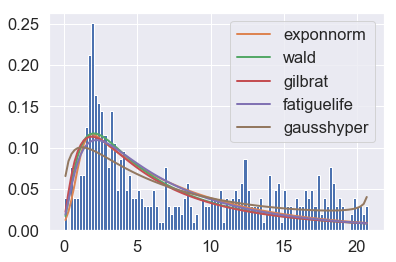

In [10]:
f_RMSD.summary()

It seems the distribution for RMSD is not really fittable by fitter using the default bin size. Let's see if increasing the bins changes anything.

In [11]:
f_RMSD = Fitter(RMSD_values, bins = 100) # can pass xmin = 7.5 if needed
f_RMSD.fit()

Fitted alpha distribution with error=0.1525302856104265, AIC=691.1042927384494, BIC=703.748117033716)
Fitted anglit distribution with error=0.19997964518828296, AIC=637.5398337189071, BIC=645.9690499157515)
Fitted arcsine distribution with error=0.2479536483453589, AIC=642.0450130229831, BIC=650.4742292198275)
Fitted argus distribution with error=0.3972713691705073, AIC=509.6958820960231, BIC=522.3397063912897)
Fitted beta distribution with error=0.1430958381660137, AIC=626.3334254439452, BIC=643.191857837634)
Fitted betaprime distribution with error=0.12736510598544173, AIC=672.0083336420487, BIC=688.8667660357374)
Fitted bradford distribution with error=0.14595620150765942, AIC=615.4888103844687, BIC=628.1326346797352)
Fitted burr distribution with error=0.1598223328144786, AIC=653.5836470607725, BIC=670.4420794544612)
Fitted burr12 distribution with error=0.13267502154235408, AIC=667.0093514811871, BIC=683.8677838748758)
Fitted cauchy distribution with error=0.19218810772715963, AIC

Fitted recipinvgauss distribution with error=0.11414167947800653, AIC=680.9462944239064, BIC=693.5901187191729)
Fitted reciprocal distribution with error=1.6914580356925772, AIC=803.2954433690161, BIC=820.1538757627048)
Fitted rice distribution with error=0.18720813169794462, AIC=655.4652928657598, BIC=668.1091171610263)
SKIPPED rv_continuous distribution(taking more than 30 seconds)
SKIPPED rv_histogram distribution(taking more than 30 seconds)
Fitted semicircular distribution with error=0.19327271700325915, AIC=622.3493265840256, BIC=630.77854278087)
Fitted skewnorm distribution with error=0.13493262755383292, AIC=655.5594660836352, BIC=668.2032903789018)
Fitted t distribution with error=0.2055491862942791, AIC=662.6416664016418, BIC=675.2854906969084)
Fitted trapz distribution with error=0.28838466836280596, AIC=679.5213744496983, BIC=696.3798068433871)
Fitted triang distribution with error=0.12633077807082213, AIC=642.1678800155186, BIC=654.8117043107851)
Fitted truncexpon distribu

sumsquare_error         AIC         BIC
exponnorm           0.102697  681.615950  694.259775
wald                0.105196  692.745542  701.174759
gilbrat             0.107186  694.899957  703.329173
fatiguelife         0.111467  684.956022  697.599846
gausshyper          0.111613  643.405665  668.693314

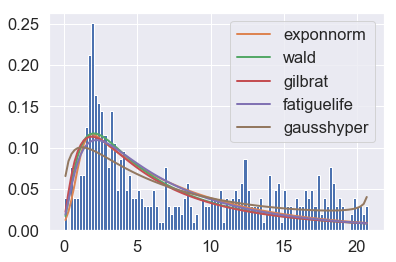

In [12]:
f_RMSD.summary()

It seems that automatic fitting is not working. More likely, this is a bimodal distribution.

[ 0.80318252 27.39029966  2.05084707  2.16088748  0.62583965  8.08385132] 
 [38.40851157 49.13464697  0.505571    0.05722925  0.07026256  0.6821878 ]


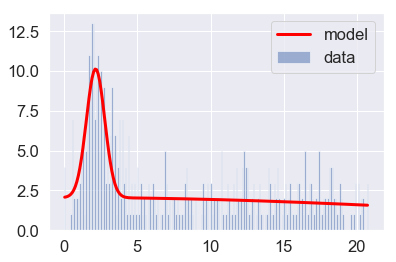

In [13]:
# https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like

# https://stackoverflow.com/questions/35990467/fit-two-gaussians-to-a-histogram-from-one-set-of-data-python

# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
# hist() returns a tuple, with the last element being a silent list of patches, so we assign this to special variable '_'
# https://hackernoon.com/understanding-the-underscore-of-python-309d1a029edc
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html

y, x, _ = hist(df['RMSD'], 200, alpha = 0.5, label = 'data')

x = (x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x, mu, sigma, A):
    return A*exp(-(x - mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x, mu1, sigma1, A1) + gauss(x, mu2, sigma2, A2)

# initial estimates for non-linear least square
expected=(15, 9, 150, 2, 0.5, 800)

# curve_fit returns popt (array of optimal params) and pcov (array of est covariance of popt)
params,cov=curve_fit(bimodal,x,y,expected)
sigma=sqrt(diag(cov))

plot(x,bimodal(x,*params),color='red',lw=3,label='model')
legend()

print(params,'\n',sigma) 

From the output above, we obtain two normal distributions that is relatively a good approximation of the RMSD data.

| Distr. | u | sigma | A
| --- | --- | --- | -- |
| Normal1 | 11.8673043 | 9.8654873 | 174.8974267 |
| Normal2 | 2.16108056 | 0.87748361 | 798.68105068 |

In [14]:
RMSD_synthetic = inverse_transform_sampling(df['RMSD'])

In [15]:
# https://plot.ly/python/histograms/

trace_experimental = go.Histogram(x = df['RMSD'], opacity= 0.75, name = 'experimental', marker = dict(color = 'yellow'))
trace_synthetic = go.Histogram(x = RMSD_synthetic, opacity= 0.75, name = 'synthetic', marker = dict(color = 'magenta'))

data = [trace_experimental, trace_synthetic]
layout = go.Layout(barmode= 'overlay', title = '<b>Figure 3: Comparison of experimental and synthetic RMSD data</b>')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

***
### <a id='TotalArea'></a>Total Surface Area

So now we have a synthetic RMSD dataset called RMSD_synthetic, let's look at how we can do something similar to others.

In [16]:
data = df['Total surface area']

f = Fitter(data, bins=200)
f.fit()

Fitted alpha distribution with error=2.1707237188119728e-07, AIC=4220.1399640897, BIC=4232.783788384966)
Fitted anglit distribution with error=4.5789934438685323e-07, AIC=4045.244752127832, BIC=4053.673968324676)
Fitted arcsine distribution with error=7.525790377613237e-07, AIC=4047.1139129938065, BIC=4055.5431291906507)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:312: RuntimeWarning:

divide by zero encountered in true_divide



Fitted argus distribution with error=7.437865554842897e-07, AIC=4002.23921257694, BIC=4014.883036872207)
Fitted beta distribution with error=2.1490935068021892e-07, AIC=4202.448560880857, BIC=4219.306993274546)
Fitted betaprime distribution with error=2.1379611803762718e-07, AIC=4212.906273667781, BIC=4229.764706061469)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:437: RuntimeWarning:

invalid value encountered in sqrt



Fitted bradford distribution with error=4.1924945642394606e-07, AIC=4011.149003598709, BIC=4023.7928278939758)
Fitted burr distribution with error=2.2948015073317094e-07, AIC=4203.874682347513, BIC=4220.7331147412015)
Fitted burr12 distribution with error=2.2259267903803587e-07, AIC=4228.147180331785, BIC=4245.005612725474)
Fitted cauchy distribution with error=2.729629405088186e-07, AIC=4325.639850549558, BIC=4334.069066746402)
Fitted chi distribution with error=1.062628559442104e-06, AIC=inf, BIC=inf)
Fitted chi2 distribution with error=1.0626261264026586e-06, AIC=590907.1371048804, BIC=590919.7809291757)
Fitted cosine distribution with error=3.826380338254269e-07, AIC=4147.19106528851, BIC=4155.620281485354)
Fitted crystalball distribution with error=1.0626285594419269e-06, AIC=inf, BIC=inf)
Fitted dgamma distribution with error=2.5103793202066296e-07, AIC=4336.61885103203, BIC=4349.262675327296)
Fitted dweibull distribution with error=2.744441046404937e-07, AIC=4323.307525541617, B

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 3.1500000000000004.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.8499999999999996.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.6999999999999993.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.8999999999999995.

E:\Program Files (x86)\M

Fitted exponpow distribution with error=1.0626285594419269e-06, AIC=inf, BIC=inf)
Fitted exponweib distribution with error=2.141099009997173e-07, AIC=4213.670915956943, BIC=4230.529348350631)
Fitted f distribution with error=2.137686241967794e-07, AIC=4211.780797656225, BIC=4228.639230049914)
Fitted fatiguelife distribution with error=9.035702754780114e-07, AIC=4499.573072083713, BIC=4512.216896378979)
Fitted fisk distribution with error=2.168267730907598e-07, AIC=4213.8434289487195, BIC=4226.487253243986)
Fitted foldcauchy distribution with error=2.585560649549101e-07, AIC=4285.4690379977965, BIC=4298.112862293063)
Fitted foldnorm distribution with error=1.0626285594419269e-06, AIC=inf, BIC=inf)
Fitted frechet_l distribution with error=1.5323427019359468e-06, AIC=5078.801103062573, BIC=5091.444927357839)
Fitted frechet_r distribution with error=1.849234706196295e-06, AIC=5036.92388840057, BIC=5049.567712695836)
Fitted gamma distribution with error=2.1318101514697862e-07, AIC=4200.8124

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:4064: RuntimeWarning:

overflow encountered in power

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:4064: RuntimeWarning:

overflow encountered in multiply

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:4064: RuntimeWarning:

invalid value encountered in true_divide



Fitted mielke distribution with error=5.394124093736337e-07, AIC=4297.882917256999, BIC=4314.741349650687)
Fitted moyal distribution with error=2.1296932628581017e-07, AIC=4203.504413446497, BIC=4211.933629643341)
Fitted nakagami distribution with error=2.2960307912029384e-07, AIC=4211.09951203324, BIC=4223.743336328506)
Fitted ncf distribution with error=2.1367378505342644e-07, AIC=4213.933144957869, BIC=4235.00618544998)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:4768: RuntimeWarning:

invalid value encountered in multiply

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:4764: RuntimeWarning:

overflow encountered in multiply



Fitted nct distribution with error=2.1559564341350962e-07, AIC=4217.6733049021805, BIC=4234.531737295869)
Fitted ncx2 distribution with error=2.851210922026635e-07, AIC=4329.781013987641, BIC=4346.639446381329)
Fitted norm distribution with error=2.9891653241663645e-07, AIC=4329.208012105237, BIC=4337.637228302081)
Fitted norminvgauss distribution with error=1.051815182545992e-06, AIC=6020.714402893185, BIC=6037.572835286874)
Fitted pareto distribution with error=8.53050024101414e-07, AIC=4260.30324046453, BIC=4272.947064759796)
Fitted pearson3 distribution with error=2.131810153237895e-07, AIC=4200.812440480033, BIC=4213.456264775299)
Fitted powerlaw distribution with error=5.145927507031198e-07, AIC=4004.2561804185207, BIC=4016.9000047137874)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5166: RuntimeWarning:

divide by zero encountered in power

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5166: RuntimeWarning:

overflow encountered in power

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5166: RuntimeWarning:

invalid value encountered in multiply



Fitted powerlognorm distribution with error=8.576104605936733e-07, AIC=4678.648539549026, BIC=4695.506971942715)
Fitted powernorm distribution with error=nan, AIC=4253.426206796152, BIC=4266.070031091418)
Fitted rayleigh distribution with error=2.425277667795342e-07, AIC=4253.647440663056, BIC=4262.0766568599)
Fitted rdist distribution with error=7.646646045635323e-07, AIC=4339.738661967845, BIC=4352.382486263111)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:5250: RuntimeWarning:

divide by zero encountered in power



Fitted recipinvgauss distribution with error=2.816291936999535e-07, AIC=4285.376873415962, BIC=4298.020697711228)
Fitted reciprocal distribution with error=1.0626285594419269e-06, AIC=inf, BIC=inf)
Fitted rice distribution with error=2.4252776486543466e-07, AIC=4255.647444487908, BIC=4268.291268783174)
SKIPPED rv_continuous distribution(taking more than 30 seconds)
SKIPPED rv_histogram distribution(taking more than 30 seconds)
Fitted semicircular distribution with error=5.262776596863107e-07, AIC=3989.137263696762, BIC=3997.5664798936064)
Fitted skewnorm distribution with error=2.1782145239415747e-07, AIC=4204.189467195424, BIC=4216.8332914906905)
Fitted t distribution with error=2.842708239014506e-07, AIC=4321.118090385566, BIC=4333.761914680832)
Fitted trapz distribution with error=9.304390733065566e-07, AIC=4102.546666280343, BIC=4119.405098674031)
Fitted triang distribution with error=2.714971301976725e-07, AIC=4070.9935172069127, BIC=4083.6373415021794)
Fitted truncexpon distribut

sumsquare_error          AIC          BIC
johnsonsu     2.128648e-07  4209.052384  4225.910817
lognorm       2.128978e-07  4206.662047  4219.305871
johnsonsb     2.129035e-07  4195.428048  4212.286480
moyal         2.129693e-07  4203.504413  4211.933630
erlang        2.131810e-07  4200.812439  4213.456263

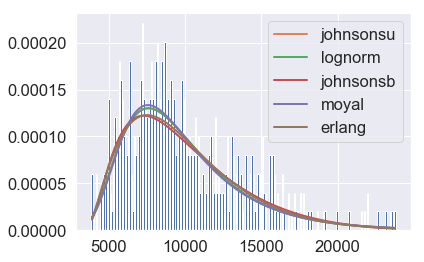

In [17]:
f.summary()

In contrast to the RMSD data, it seems the Total surface area can be easily approximated by these 5 distributions. However, looking at the (`numpy.random` documentation)[https://www.numpy.org/devdocs/reference/routines.random.html], the only standard method to generate random numbers is through the `numpy.random.f` (F distribution). This is one of the main problems of fitting a curve first and then trying to figure out how to generate random numbers that follows a particular distribution. The inverse transform sampling is much easier.

In any case, for illustrative purposes, we will use the F distribution.

Let's first generate moyal because it has the lowest error, though all of them are actually relatively similar.

And then we will use inverse transform sampling to make another set of random numbers. Overlay all for comparison.

In [18]:
f.fitted_param['f']

(2403.152948792157, 15.180590402229322, -34.17213947585707, 8645.415274223475)

From scipy documentation, the F pdf is of the form pdf(x, dfn, dfd, loc=0, scale=1) meaning:

dfn: 2361.6060387471257
dfd: 13.72970737340411
loc: -33.606132263020314
scale: 8509.57037876677

In [26]:
# generate random numbers according to F distribution

TotalArea_random = (np.random.f(2361.6060387471257, 13.72970737340411, 500) * 8509.57037876677 ) + 33.606132263020314

In [27]:
TotalArea_synthetic = inverse_transform_sampling(df['Total surface area'])

trace_experimental = go.Histogram(x = df['Total surface area'], opacity= 0.75, name = 'experimental',
                                  marker = dict(color = 'yellow'))
trace_synthetic = go.Histogram(x = TotalArea_synthetic, opacity= 0.75, name = 'synthetic',
                                   marker = dict(color = 'magenta'))

trace_random = go.Histogram(x = TotalArea_random, opacity= 0.5, name = 'random',
                                   marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random]

# https://plot.ly/python/text-and-annotations/

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 4: Comparison of experimental and synthetic Total Surface Area data</b>',
    annotations=[
        dict(
            x=15000,
            y=350,
            xref='x',
            yref='y',
            text='<i>shoulder not captured by curve fitting of <br>standard distribution</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=200,
            ay=-40,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

While our random numbers closely mimic the experimental data, it does not fully capture the subtleties present, for instance, the shoulder around (x = 15k, y = 380) (annotated above).

***
### <a id='NonpolarExposedArea'></a>Non-polar exposed area

Let's look at Non-polar exposed area now.



In [21]:
f = Fitter(df['Non-polar exposed area'], bins=200)
f.fit()

Fitted alpha distribution with error=1.1249077593534422e-06, AIC=3975.057436066203, BIC=3987.70126036147)
Fitted anglit distribution with error=3.2002150133744093e-06, AIC=3718.272337556132, BIC=3726.701553752976)
Fitted arcsine distribution with error=5.290892808590757e-06, AIC=3752.4758089525867, BIC=3760.905025149431)
Fitted argus distribution with error=5.0764014485204395e-06, AIC=3657.4227017311096, BIC=3670.0665260263763)
Fitted beta distribution with error=1.1089525450050301e-06, AIC=3976.2261258720127, BIC=3993.0845582657016)
Fitted betaprime distribution with error=1.1143787233214523e-06, AIC=3957.5897532169997, BIC=3974.4481856106886)
Fitted bradford distribution with error=4.3789786085571014e-06, AIC=3749.51426995458, BIC=3762.1580942498467)
Fitted burr distribution with error=1.3247734621483446e-06, AIC=3930.9017251772802, BIC=3947.760157570969)
Fitted burr12 distribution with error=4.553993396491621e-06, AIC=4222.728113024097, BIC=4239.586545417786)
Fitted cauchy distribut

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:768: RuntimeWarning:

overflow encountered in power



Fitted chi2 distribution with error=4.757627179428515e-05, AIC=53881.24509000664, BIC=53893.888914301904)
Fitted cosine distribution with error=2.652996579549548e-06, AIC=3842.7683147941325, BIC=3851.1975309909767)
Fitted crystalball distribution with error=6.531757929781599e-06, AIC=inf, BIC=inf)
Fitted dgamma distribution with error=1.517942520493544e-06, AIC=4125.971160511833, BIC=4138.614984807099)
Fitted dweibull distribution with error=1.43498296161388e-06, AIC=4147.691417090853, BIC=4160.335241386119)
Fitted erlang distribution with error=2.3584164294368413e-05, AIC=91667.57242086163, BIC=91680.2162451569)
Fitted expon distribution with error=2.8055477885582136e-06, AIC=3850.174417172093, BIC=3858.603633368937)


E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.1.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.0666666666666664.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.1111111111111107.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:2562: RuntimeWarning:

The shape parameter of the erlang distribution has been given a non-integer value 2.166666666666666.

E:\Program Files (x86)\Microsoft Visual 

Fitted exponnorm distribution with error=1.140815065727025e-06, AIC=3947.655696462577, BIC=3960.2995207578438)
Fitted exponpow distribution with error=6.531757929781599e-06, AIC=inf, BIC=inf)
Fitted exponweib distribution with error=1.1066224104692282e-06, AIC=3971.566964321766, BIC=3988.425396715455)
Fitted f distribution with error=1.1076130315357923e-06, AIC=3970.859537148482, BIC=3987.717969542171)
Fitted fatiguelife distribution with error=7.017014480900145e-06, AIC=4177.185105972625, BIC=4189.828930267891)
Fitted fisk distribution with error=1.1357261935617089e-06, AIC=3954.42408887938, BIC=3967.067913174647)
Fitted foldcauchy distribution with error=1.453906549450288e-06, AIC=3980.4051764906662, BIC=3993.049000785933)
Fitted foldnorm distribution with error=6.531757929781599e-06, AIC=inf, BIC=inf)
Fitted frechet_l distribution with error=9.378948984139842e-06, AIC=4702.835039965159, BIC=4715.478864260425)
Fitted frechet_r distribution with error=1.3473335767978767e-05, AIC=4596.

E:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\lib\site-packages\scipy\stats\_continuous_distns.py:3080: RuntimeWarning:

invalid value encountered in power



Fitted gausshyper distribution with error=1.1210775676958287e-06, AIC=3970.473140154838, BIC=3995.760788745371)
Fitted genexpon distribution with error=2.67615403870674e-06, AIC=3891.5727472666213, BIC=3912.6457877587322)
Fitted genextreme distribution with error=1.1169270544416416e-06, AIC=3969.0648921731345, BIC=3981.7087164684012)
Fitted gengamma distribution with error=2.7980769717527657e-06, AIC=3853.2955342700075, BIC=3870.1539666636963)
Fitted genhalflogistic distribution with error=1.6888969762441146e-06, AIC=3970.7265593862076, BIC=3983.3703836814743)
Fitted genlogistic distribution with error=1.1645399262485252e-06, AIC=4024.9557190731016, BIC=4037.5995433683684)
Fitted gennorm distribution with error=1.4900020502275206e-06, AIC=4148.481859693784, BIC=4161.12568398905)
Fitted genpareto distribution with error=2.1569029457358586e-06, AIC=3898.8073444291726, BIC=3911.4511687244394)
Fitted gilbrat distribution with error=1.7854602743971293e-06, AIC=3843.161077960625, BIC=3851.59

sumsquare_error          AIC          BIC
norminvgauss         0.000001  3968.697500  3985.555932
johnsonsb            0.000001  3970.483162  3987.341595
johnsonsu            0.000001  3966.687285  3983.545717
exponweib            0.000001  3971.566964  3988.425397
f                    0.000001  3970.859537  3987.717970

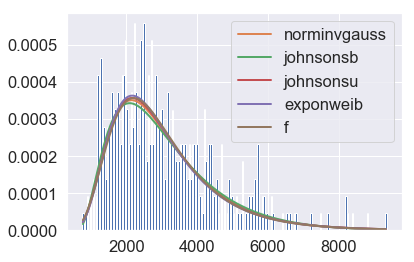

In [22]:
f.summary()

For this data, it seems none of the best-fitting distributions are available to be used directly through `numpy.random`. We can use the rvs method instead.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponnorm.html#scipy.stats.exponnorm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.moyal.html

Moyal takes 3 parameters - K, loc and scale.


In [23]:
# create synthetic data
NonpolarExposedArea_random_moyal = moyal.rvs(f.fitted_param['moyal'][0], f.fitted_param['moyal'][1], 40000)
NonpolarExposedArea_random_exponnorm = exponnorm.rvs(f.fitted_param['exponnorm'][0],
                                                     f.fitted_param['exponnorm'][1], f.fitted_param['exponnorm'][2], 40000)

NonpolarExposedArea_InvTS = inverse_transform_sampling(df['Non-polar exposed area'])

In [24]:
# plot original and synthetic data

trace_experimental = go.Histogram(x = df['Non-polar exposed area'], opacity= 0.75, name = 'experimental',
                                  marker = dict(color = 'yellow'))
trace_synthetic = go.Histogram(x = NonpolarExposedArea_InvTS, opacity= 0.75, name = 'synthetic by ITS',
                                   marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = NonpolarExposedArea_random_moyal, opacity= 0.5, name = 'random moyal',
                                   marker = dict(color = 'blue'))

trace_random2 = go.Histogram(x = NonpolarExposedArea_random_exponnorm, opacity= 0.55, name = 'random exponnorm',
                                   marker = dict(color = 'green'))

data = [trace_experimental, trace_synthetic, trace_random1, trace_random2]

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 5: Comparison of experimental and synthetic Non-polar exposed area data</b>'
    annotations=[
        dict(
            x=2200,
            y=850,
            xref='x',
            yref='y',
            text='<i>peak not fully captured by both ITS and <br>random numbers from standard distributions</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=200,
            ay=-40,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

SyntaxError: invalid syntax (<ipython-input-24-4bb9fa6316cc>, line 18)

***
### <a id='FractionalAreaExposedNonPolarResidue'></a> Fractional area of exposed non polar residue

Fractional area of exposed non polar residue

In [ ]:
f = Fitter(df['Fractional area of exposed non polar residue'], bins=200)
f.fit()

In [ ]:
f.summary()

Given the shape and error, it seems the Johnson SU (unbounded support) [https://www.rdocumentation.org/packages/ExtDist/versions/0.6-3/topics/JohnsonSU] distribution is the best fit.

It also seems that we don't have any special 'features', e.g. atypical shoulders that needs to be included.

Also, it looks like we can model it as a normal distribution, but somehow this isn't showing up in the fit summary.

In [ ]:
# create synthetic data

FractionalAreaExposedNonPolarResidue_random_johnsonsu = johnsonsu.rvs(f.fitted_param['johnsonsu'][0],
                                                                      f.fitted_param['johnsonsu'][1],
                                                                      f.fitted_param['johnsonsu'][2],
                                                                      f.fitted_param['johnsonsu'][3], 40000)

FractionalAreaExposedNonPolarResiduea_random_norm = norm.rvs(f.fitted_param['norm'][0],
                                                     f.fitted_param['norm'][1], 40000)

FractionalAreaExposedNonPolarResidue_InvTS = inverse_transform_sampling(df['Fractional area of exposed non polar residue'])

In [ ]:
# plot original and synthetic data

trace_experimental = go.Histogram(x = df['Fractional area of exposed non polar residue'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = FractionalAreaExposedNonPolarResidue_InvTS, opacity= 0.75, name = 'synthetic by ITS',
                                   marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = FractionalAreaExposedNonPolarResidue_random_johnsonsu, opacity= 0.5,
                                   name = 'random johnson su',
                                   marker = dict(color = 'blue'))

trace_random2 = go.Histogram(x = FractionalAreaExposedNonPolarResiduea_random_norm, opacity= 0.55,
                                   name = 'random norm',
                                   marker = dict(color = 'green'))

data = [trace_experimental, trace_synthetic, trace_random1, trace_random2]

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 6: Comparison of experimental and synthetic <br>' +
                   'Fractional area of exposed non polar residue data</b>')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Turns out normal distribution is just as good as Johnson's SU.

***
### <a id='FractionalAreaExposedNonPolarPartOfResidue'></a>Fractional area of exposed non polar part of residue

In [ ]:
f = Fitter(df['Fractional area of exposed non polar part of residue'], bins=200)
f.fit()

In [ ]:
f.summary()

This data is a bit complicated to model adequately with the presence of several minor peaks. This is another example where ITS will be quite useful.

And probably a better solution, similar to the first column...

In [ ]:
f.fitted_param['exponnorm']

In [ ]:
# create synthetic data

FractionalAreaExposedNonPolarPartOfResidue_random_exponnorm = exponnorm.rvs(f.fitted_param['exponnorm'][0],
                                                                      f.fitted_param['exponnorm'][1],
                                                                      f.fitted_param['exponnorm'][2], 40000)

FractionalAreaExposedNonPolarPartOfResidue_InvTS = inverse_transform_sampling(
                                                    df['Fractional area of exposed non polar part of residue'])

In [ ]:
# plot original and synthetic data

trace_experimental = go.Histogram(x = df['Fractional area of exposed non polar part of residue'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = FractionalAreaExposedNonPolarPartOfResidue_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = FractionalAreaExposedNonPolarPartOfResidue_random_exponnorm, opacity= 0.5,
                                  name = 'random exponnorm',
                                  marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random1]

layout = go.Layout(barmode = 'overlay', title = '<b>Figure 7: Comparison of experimental and synthetic <br>' +
                   'Fractional area of exposed non polar part of residue data</b>',
    annotations=[
        dict(
            x=200,
            y=400,
            xref='x',
            yref='y',
            text='<i>minor peaks not fully captured by <br>random numbers from exponnorm</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=70,
            ay=-50,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Again, we see that the random numbers from exponnorm distribution does not fully capture the subtle nuances of the data. While it could be that some of these are outliers, we cannot be entirely certain of this.

***
### <a id='MolecularMassWeightedExposedArea'></a> Molecular mass weighted exposed area

Let's look at the molecular mass weighted exposed area.

In [ ]:
f = Fitter(df['Molecular mass weighted exposed area'], bins=200)
f.fit()

In [ ]:
f.summary()

In [ ]:
MolecularMassWeightedExposedArea_random_moyal = moyal.rvs(f.fitted_param['moyal'][0],
                                                                      f.fitted_param['moyal'][1], 40000)

MolecularMassWeightedExposedArea_InvTS = inverse_transform_sampling(
                                                    df['Molecular mass weighted exposed area'])

In [ ]:
# plot original and synthetic data

trace_experimental = go.Histogram(x = df['Molecular mass weighted exposed area'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = MolecularMassWeightedExposedArea_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = MolecularMassWeightedExposedArea_random_moyal, opacity= 0.5,
                                  name = 'random moyal',
                                  marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random1]

# https://plot.ly/python/text-and-annotations/

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 8: Comparison of experimental and synthetic <br>' +
                   'Molecular mass weighted exposed area data</b>',
    annotations=[
        dict(
            x=2.4e+6,
            y=300,
            xref='x',
            yref='y',
            text='<i>minor peak not fully captured by <br>random numbers from moyal distribution</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=80,
            ay=-50,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

xxxx
***
### <a id='AverageDeviationFromStandardExposedAreaOfResidue'></a>Average deviation from standard exposed area of residue



In [ ]:
f = Fitter(df['Average deviation from standard exposed area of residue'], bins=200)
f.fit()

In [ ]:
f.summary()

Let's create random numbers and do ITS and plot all of them.

Note: for some reason, probably due to the extreme values (tail), we have to request only 20000 values to generate synthetic data that match the experimental.

In [ ]:
# create synthetic data - inverse_transform_sampling(data, n_bins=200, n_samples=40000)

AverageDeviationFromStandardExposedAreaOfResidue_random_exponnorm = exponnorm.rvs(f.fitted_param['exponnorm'][0],
                                                                      f.fitted_param['exponnorm'][1],
                                                                      f.fitted_param['exponnorm'][2], 20000)

AverageDeviationFromStandardExposedAreaOfResidue_InvTS = inverse_transform_sampling(
                                                    df['Average deviation from standard exposed area of residue'],
                                                    n_samples = 20000)

In [ ]:
# plot original and synthetic data

trace_experimental = go.Histogram(x = df['Average deviation from standard exposed area of residue'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = AverageDeviationFromStandardExposedAreaOfResidue_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = AverageDeviationFromStandardExposedAreaOfResidue_random_exponnorm, opacity= 0.5,
                                  name = 'random exponnorm',
                                  marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random1]

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 9: Comparison of experimental and synthetic <br>' +
                   'Average deviation from standard exposed area of residue data</b>',
    annotations=[
        dict(
            x=300,
            y=200,
            xref='x',
            yref='y',
            text='<i>peak shoulder not fully captured by <br>random numbers from exponnorm</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=70,
            ay=-50,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

xxx
***
### <a id='EuclidianDistance'></a> Euclidian distance

In [ ]:
f = Fitter(df['Euclidian distance'], bins=200)
f.fit()

In [ ]:
f.summary()

Seems like genlogistic is a good fit, as in johnson SU.

In [ ]:
# create synthetic data

EuclidianDistance_random_genlogistic = genlogistic.rvs(f.fitted_param['genlogistic'][0],
                                                                      f.fitted_param['genlogistic'][1],
                                                                      f.fitted_param['genlogistic'][2], 40000)

EuclidianDistance_InvTS = inverse_transform_sampling(df['Euclidian distance'])

In [ ]:
# plot original and synthetic data
# for inset: https://plot.ly/python/insets/
# we use showlegend=False for the inset traces to hide them from the legend, otherwise we'll be seeing double entries
# https://plot.ly/python/legend/#hide-legend-entries

trace_experimental = go.Histogram(x = df['Euclidian distance'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = EuclidianDistance_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = EuclidianDistance_random_genlogistic, opacity= 0.5,
                                  name = 'random genlogistic',
                                  marker = dict(color = 'blue'))

trace_experimental_inset = go.Histogram(x = df['Euclidian distance'], opacity= 0.75,
                                  name = 'experimental', showlegend = False,
                                  marker = dict(color = 'yellow'), xaxis = 'x2', yaxis='y2')

trace_synthetic_inset = go.Histogram(x = EuclidianDistance_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS', showlegend = False,
                                  marker = dict(color = 'magenta'), xaxis = 'x2', yaxis='y2')

trace_random1_inset = go.Histogram(x = EuclidianDistance_random_genlogistic, opacity= 0.5,
                                  name = 'random genlogistic', showlegend = False,
                                  marker = dict(color = 'blue'), xaxis = 'x2', yaxis='y2')

data = [trace_experimental, trace_synthetic, trace_random1,
        trace_experimental_inset, trace_synthetic_inset, trace_random1_inset]

# https://plot.ly/python/text-and-annotations/

layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 10: Comparison of experimental and synthetic <br>' +
                   'Euclidian distance data</b>',
    
    xaxis2 = dict(domain = [0.6, 0.95], anchor = 'y2', range = [0,10000]),
    yaxis2 = dict(domain = [0.6, 0.95], anchor = 'x2'),
                   
    annotations=[
        dict(
            x=10000,
            y=1500,
            xref='x',
            yref='y',
            text='<i>experimental peak is not <br>fully captured by <br>random numbers from genlogistic</i>',
            showarrow=True,
            arrowhead=2,
            arrowwidth = 2,
            arrowsize = 1,
            ax=100,
            ay=50,
            align = 'center'
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

xxx
***
### <a id='SecondaryStructurePenalty'></a> Secondary structure penalty

In [ ]:
f = Fitter(df['Secondary structure penalty'], bins=200)
f.fit()

In [ ]:
f.summary()

For this case, several distributions have similar error values. It is best to adapt Occam's razor, choose the most parsimounous model. Let's use invgauss.

In [ ]:
# create synthetic data

SecondaryStructurePenalty_random_invgauss = invgauss.rvs(f.fitted_param['invgauss'][0],
                                                                      f.fitted_param['invgauss'][1],
                                                                      f.fitted_param['invgauss'][2], 40000)

SecondaryStructurePenalty_InvTS = inverse_transform_sampling(df['Secondary structure penalty'])

In [ ]:
trace_experimental = go.Histogram(x = df['Secondary structure penalty'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = SecondaryStructurePenalty_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = SecondaryStructurePenalty_random_invgauss, opacity= 0.5,
                                  name = 'random invgauss',
                                  marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random1]

# the maximum value in the experimental data is 350 but invgauss.rvs made data up to about 600
# therefore, we will rescale the plot on xaxis
layout = go.Layout(barmode = 'overlay',
                   title = '<b>Figure 10: Comparison of experimental and synthetic <br>' +
                   'Secondary structure penalty data</b>',
                   xaxis=dict(range=[0, 500]))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

xxx
***
### <a id='SpatialDistributionConstraints'></a> Spatial distribution constraints

In [ ]:
f = Fitter(df['Spatial Distribution constraints (N,K Value)'], bins=200)
f.fit()

In [ ]:
f.summary()

In [ ]:
f.fitted_param['burr']

In [ ]:
# create synthetic data

SpatialDistributionConstraints_random_burr = burr.rvs(f.fitted_param['burr'][0], f.fitted_param['burr'][1],
                                                      f.fitted_param['burr'][2], f.fitted_param['burr'][3], 40000)

SpatialDistributionConstraints_InvTS = inverse_transform_sampling(df['Spatial Distribution constraints (N,K Value)'])

In [ ]:
trace_experimental = go.Histogram(x = df['Spatial Distribution constraints (N,K Value)'], opacity= 0.75,
                                  name = 'experimental',
                                  marker = dict(color = 'yellow'))

trace_synthetic = go.Histogram(x = SpatialDistributionConstraints_InvTS, opacity= 0.75,
                                  name = 'synthetic by ITS',
                                  marker = dict(color = 'magenta'))

trace_random1 = go.Histogram(x = SpatialDistributionConstraints_random_burr, opacity= 0.5,
                                  name = 'random burr',
                                  marker = dict(color = 'blue'))

data = [trace_experimental, trace_synthetic, trace_random1]

layout = go.Layout(barmode = 'overlay', title = '<b>Figure 11: Comparison of experimental and synthetic <br>' +
                   'Spatial Distribution constraints (N,K Value) data</b>')

fig = go.Figure(data=data, layout=layout)
iplot(fig)

xxx

***
## Discussion

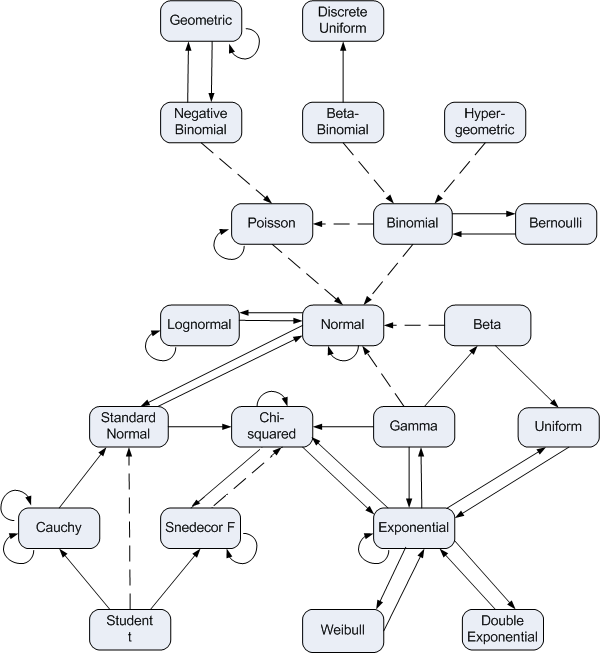

Taken from https://www.johndcook.com/blog/distribution_chart/ with the original reference to a paper by Lawrence M. LEEMIS and Jacquelyn T. MCQUESTON http://www.math.wm.edu/~leemis/2008amstat.pdf

also: https://en.wikipedia.org/wiki/Relationships_among_probability_distributions

1. collect all the synthetic values (ITS + rvs) into pandas DataFrames separately
1. do df.describe() and box/violin plots
1. calculate heatmaps and compare those, or make corrplot (better??)



***
## Conclusion